In [1]:
import glob
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdatesx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import List

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We're going to use the [daily report data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) from the **2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE** in order to compare recent trends in confirmed cases across various regions.

In order to read this data in, we're going to need a few utilities:

In [3]:
def list_source_files(dir_name: str) -> List[str]: 
    """Returns a list of all the source files."""
    pattern = r"(\d{2}-\d{2}-\d{4}).csv"
    src = "{}/*.csv".format(dir_name)
    return [f for f in glob.glob(src) if re.search(pattern, f)]

def date_for_file(filename: str) -> str:
    pattern = r"(\d{2})-(\d{2})-(\d{4}).csv"
    m = re.findall(pattern, filename)
    return pd.Timestamp("{}-{}-{}".format(m[0][2], m[0][0], m[0][1]))

assert date_for_file("csse_covid_19_daily_reports/02-22-2020.csv") == pd.Timestamp('2020-02-22 00:00:00')

def read_combined_daily_data(file_names: List[str], rename_cols_map):
    """Reads in all the data, combines it in single DataFrame."""
    # Note handling inconsistent column names
    dfs = []
    for f in files:
        df = pd.read_csv(f).rename(columns=rename_cols_map)
        # Many problems with 'Last Update': incorrect values, inconsistent format. 
        #   Infer from filename instead.
        df['Last Update'] = date_for_file(f)
        dfs.append(df)
    data = pd.concat(dfs)
    return data

### Read data

We're going to read all the data from the various daily reports into a single combined pandas `DataFrame`.

In [4]:
DIR = "csse_covid_19_daily_reports"

RENAME_COLS = { 'Country_Region': 'Country/Region', 'Province_State': 'Province/State' }

# Read in data as single DataFrame
files = list_source_files(DIR)

assert len(list_source_files(DIR)) >= 66 # Min required range: 1/22 - 3/7

data = read_combined_daily_data(files, RENAME_COLS)

Here's a sample of the data:

In [5]:
data.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,FIPS,Admin2,Last_Update,Lat,Long_,Active,Combined_Key,Latitude,Longitude
0,Hubei,Mainland China,2020-02-26,65187.0,2615.0,20969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Guangdong,Mainland China,2020-02-26,1347.0,7.0,851.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Henan,Mainland China,2020-02-26,1271.0,19.0,1033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,South Korea,2020-02-26,1261.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Zhejiang,Mainland China,2020-02-26,1205.0,1.0,867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean data

The data has several inconsistencies and challenges. We fixed the following above while reading in the data:

* Inconsistent column names
* Data quality issues, and inconsistent timestamp formats, with values in `Last Update` column

Additionally, we'll fix the following below:

* Variable number of columns and content
* `NaN` values for confirmed column
* Superfluous columns
* Varying levels of granularity of data

In [6]:
# Cleanup: select columns NaN -> 0
data['Confirmed'] = data['Confirmed'].fillna(0)

# Normalize "Date" field
data = data.reset_index() # Not strictly needed, but prevents error if re-run this cell

# Remove unused columns
COLUMNS_TO_KEEP = ['Province/State', 'Country/Region', 'Last Update', 'Confirmed']
data = data[COLUMNS_TO_KEEP]

Also, let's set `Last Update` to be the index, so we can access data using date ranges:

In [7]:
data = data.set_index('Last Update')
data = data.sort_values(by=['Last Update'])

E.g., we can access the 895 rows corresponding to the date range 3/19 - 3/21:

In [8]:
data.loc['2020-03-19':'2020-03-21']

,Province/State,Country/Region,Confirmed
Last Update,,,
2020-03-19,NaN,Albania,64.0
2020-03-19,NaN,Cyprus,67.0
2020-03-19,NaN,Bosnia and Herzegovina,63.0
2020-03-19,NaN,Morocco,63.0
2020-03-19,Arkansas,US,62.0
...,...,...,...
2020-03-21,South Carolina,US,171.0
2020-03-21,NaN,Serbia,171.0
2020-03-21,NaN,Kuwait,176.0


Starting 3/22, the rows become more granular. E.g., instead of having just one row for the state of New York, it has 45 rows, including one for New York City, one for Albany, etc.

Below, we're going to aggregate the rows back to the level of province or state:

In [9]:
# Ensure provinces have unique values to help w/ groupby
data['Province/State'] = data.apply(
    func=lambda row: row['Province/State'] if not pd.isnull(row['Province/State']) else row['Country/Region'],
    axis=1
)

# Aggregate anything more granular than. province/state, which are not uniformly available on all dates
data = data.groupby([data.index, 'Country/Region', 'Province/State']) \
    .sum() \
    .reset_index() \
    .set_index('Last Update') \
    .sort_values(by=['Province/State','Country/Region','Last Update'])

### Add daily confirmed counts 

The `Confirmed` column is the cumulative number of cases. 

In order to analyze daily new confirmed cases, let's add a new column, `Daily Confirmed`, which will contain the new cases discovered in a given day:

In [10]:
# Create Daily Confirmed column
data['Daily Confirmed'] = data['Confirmed'] - data['Confirmed'].shift() \
    .where(cond=data['Province/State'].shift() == data['Province/State']) \
    .where(cond=data['Country/Region'].shift() == data['Country/Region']) 

data['Daily Confirmed'] = data['Daily Confirmed'].fillna(0)

data = data.sort_values(by=['Last Update'])

# Some data quality assertions
assert data[data['Country/Region'] == 'Italy'].size >= 140
ny = data[(data['Country/Region'] == 'US') & (data['Province/State'] == 'New York')]
assert ny.size >= 68
assert np.array_equal(ny['2020-03-10':'2020-03-14']['Confirmed'].values, [173, 220, 328, 421, 525])

# Let's view NY state data
ny.tail()

,Country/Region,Province/State,Confirmed,Daily Confirmed
Last Update,,,,
2020-03-23,US,New York,20884.0,5084.0
2020-03-24,US,New York,25681.0,4797.0
2020-03-25,US,New York,30841.0,5160.0
2020-03-26,US,New York,37877.0,7036.0
2020-03-27,US,New York,44876.0,6999.0


## Worldwide confirmed cases

We'll be creating a lot of graphs demonstrating how confirmed cases are growing, so let's create a utility that will make this easy:

In [11]:
# Source for date formatting legibility tricks: https://stackoverflow.com/a/43631028
def plot_time_series_data(
    x_col, 
    y_col, 
    y_label = "Missing Label",
    title = "Missing title",
    benchmark_1 = None, 
    benchmark_1_label = "Missing Label",
    benchmark_2 = None,
    benchmark_2_label = "Missing Label"
    
):
    """Renders a line graph for time series data, making graph more legible"""
    fig, ax = plt.subplots()
    
    ax.plot(x_col, y_col, label=y_label)
    
    if benchmark_1 is not None:
        ax.plot(x_col, benchmark_1,'--', label=benchmark_1_label)
    
    if benchmark_2 is not None:
        ax.plot(x_col, benchmark_2,'--', label=benchmark_2_label)
    
    # make dates legible
    md_fmt = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(md_fmt)
    ax.legend(loc='upper left')
    
    # rotate dates to improve legibility
    fig.autofmt_xdate()
    plt.title(title)
    plt.show()

Let's look at worldwide cumulative confirmed cases:

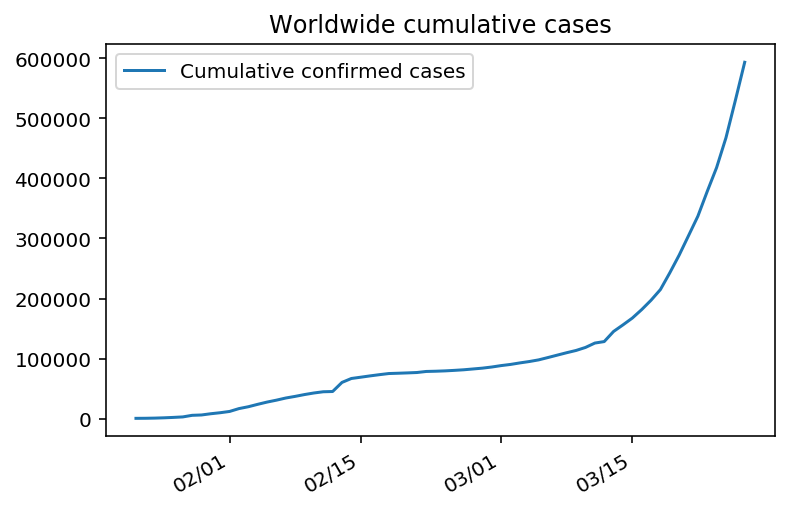

In [12]:
world = data.groupby(data.index).sum()
plot_time_series_data(
    x_col = world.index, 
    y_col = world['Confirmed'],
    y_label = 'Cumulative confirmed cases',
    title = 'Worldwide cumulative cases'
)

The daily confirmed worldwide cases are noisy between 3/12 and 3/27:

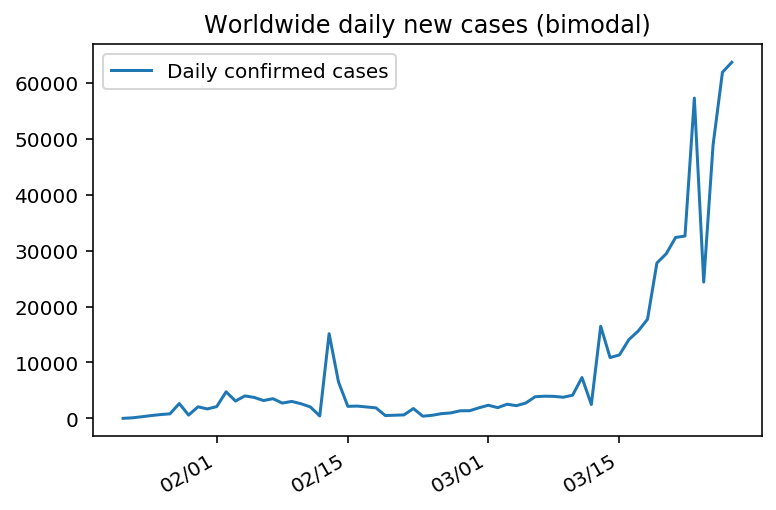

In [13]:
plot_time_series_data(
    x_col = world.index, 
    y_col = world["Daily Confirmed"],
    y_label = 'Daily confirmed cases',
    title = 'Worldwide daily new cases (bimodal)'
)

If you look closely, this function looks bimodal. Let's trim off the first mode, which seems to end around 2/25 or so:

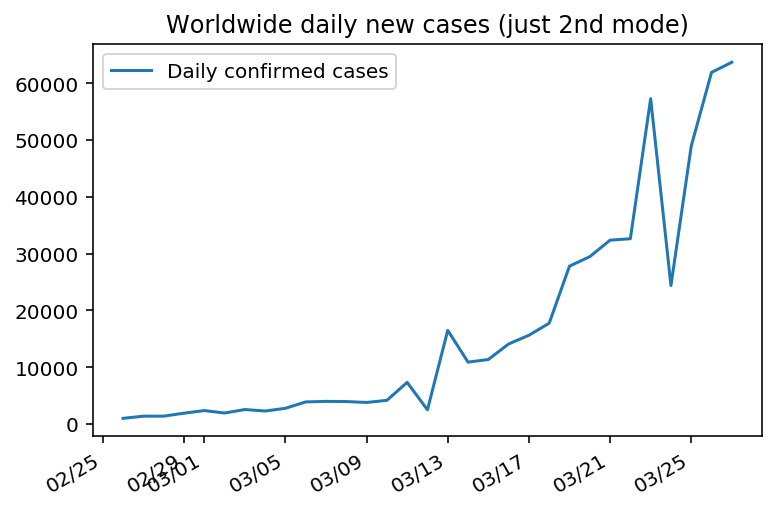

In [14]:
world = world['2020-02-26':]
plot_time_series_data(
    x_col = world.index, 
    y_col = world["Daily Confirmed"],
    y_label = 'Daily confirmed cases',
    title = 'Worldwide daily new cases (just 2nd mode)'
)

## Modeling worldwide confirmed cases as a regression

Let's fit this data to a polynomial curve, as a benchmark to help us understand the daily confirmed case rates rate of change across different regions.

Before doing this, some utilities that will help us:

In [15]:
# TODO: this is high. What's reasonable?
DEFAULT_POLYNOMIAL_DEGRESS = 5

def dates_to_date_offsets(dates):
    min_date = dates.min()
    DAY = 1e9 * 3600 * 24
    fn = lambda date: int((date - min_date).item() / DAY)
    return np.array(list(map(fn, dates)))

assert np.array_equal(dates_to_date_offsets(world.index.values[2:6]), [0, 1, 2, 3])

def polynomial_date_offsets(X, degree=DEFAULT_POLYNOMIAL_DEGRESS):
    assert X.shape[0] > 1  # Must not pass in one day of data
    assert X.shape[1] == 1
    poly_feat = PolynomialFeatures(degree)
    return poly_feat.fit_transform(X)

def polynomial_regression(X, y):
    assert y.shape == X.shape
    X_poly = polynomial_date_offsets(X)
    model = LinearRegression()
    return model.fit(X_poly, y)

As a proof of concept, let's start with fitting the data using raw observations:

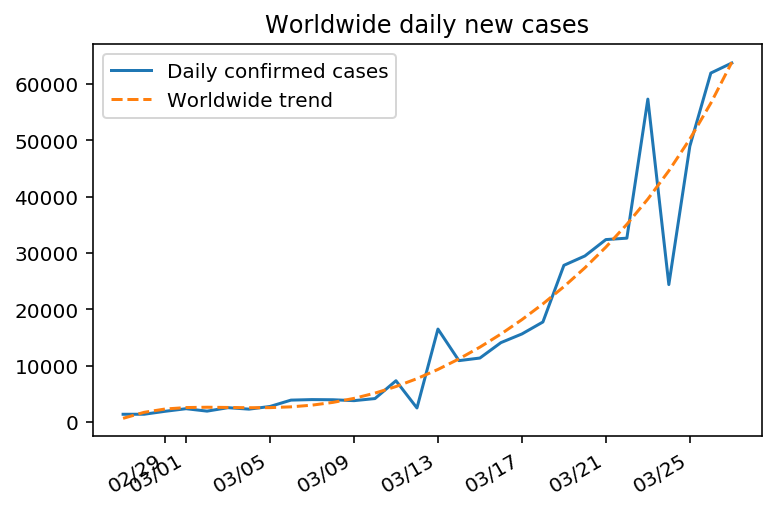

In [16]:
# Fit model
world_date_offsets = dates_to_date_offsets(world.index.values).reshape(-1, 1)[1:]
world_confirmed_obs = world["Daily Confirmed"].values.reshape(-1, 1)[1:]
world_confirmed_model = polynomial_regression(world_date_offsets, world_confirmed_obs)

# Graph predictions
world_predictions = world_confirmed_model.predict(polynomial_date_offsets(world_date_offsets))
plot_time_series_data(
    x_col = world.index[1:], 
    y_col = world["Daily Confirmed"][1:],
    y_label = 'Daily confirmed cases',
    benchmark_1 = np.array(world_predictions),
    benchmark_1_label = 'Worldwide trend',
    title = 'Worldwide daily new cases'
)

The problem with the above approach that it'll predict the absolute number of cases. We need to normalize this to be a rate, so we can compare against regions of different scales (say USA, Italy, or even DC).

We'll calculate the number of confirmed cases per million individuals:

In [17]:
def instances_per_million(obs, population):
    RATE_SIZE = 1_000_000
    return obs * RATE_SIZE / population 

def normalize_observations(values, population):
    values = map(lambda x: instances_per_million(x, population), values)
    return np.array(list(values))

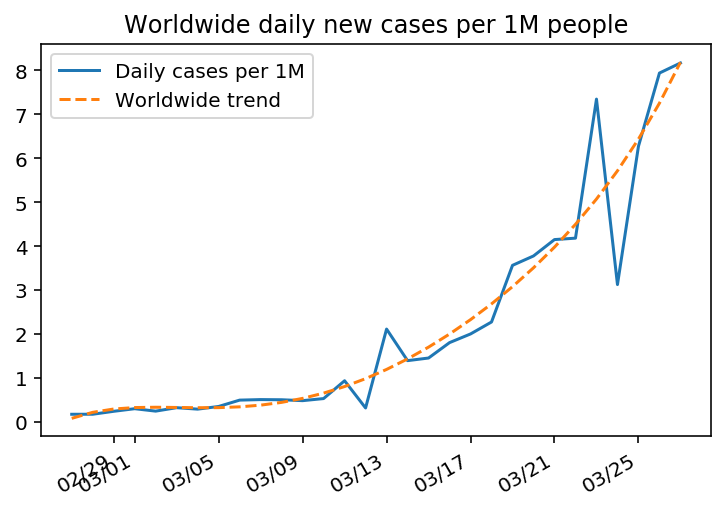

In [18]:
WORLD_POPULATION = 7_800_000_000

# Refit model
world_date_offsets = dates_to_date_offsets(world.index.values).reshape(-1, 1)[1:]
world_confirmed_obs = normalize_observations(world["Daily Confirmed"].values, WORLD_POPULATION)
world_confirmed_model = polynomial_regression(world_date_offsets, world_confirmed_obs.reshape(-1, 1)[1:])

# Graph predictions
world_predictions = world_confirmed_model.predict(polynomial_date_offsets(world_date_offsets))
plot_time_series_data(
    x_col = world.index[1:], 
    y_col = world_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(world_predictions),
    benchmark_1_label = 'Worldwide trend',
    title = 'Worldwide daily new cases per 1M people'
)

### Hubei
Let's look at Hubei confirmed cases:

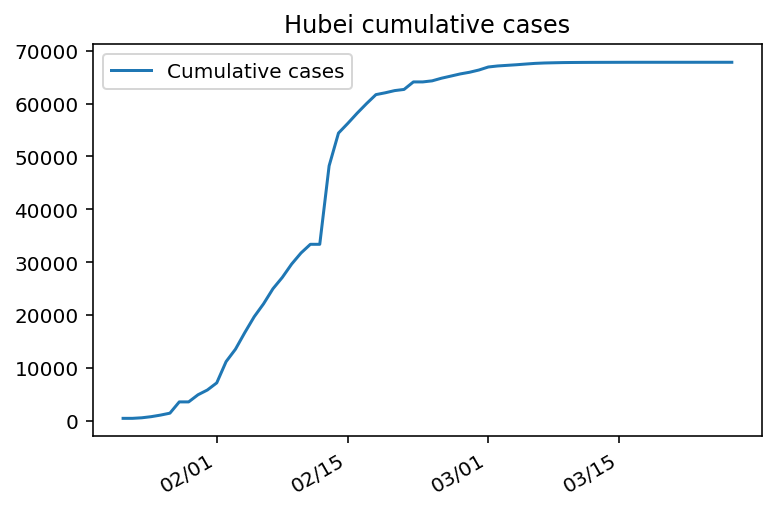

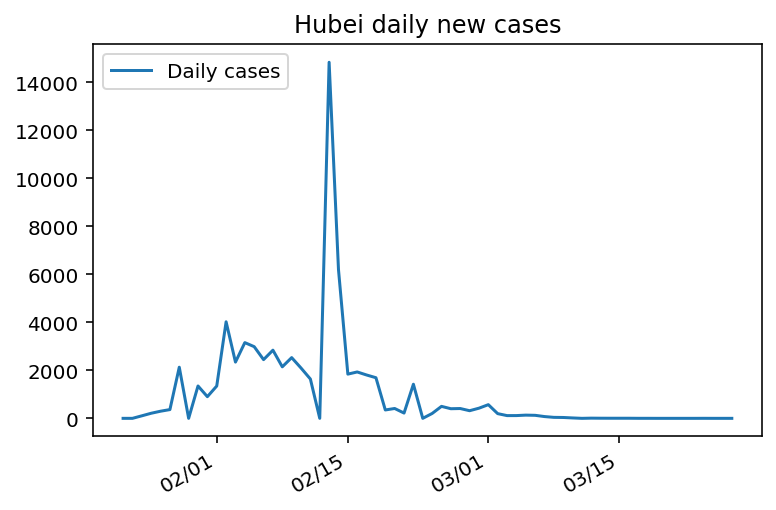

In [19]:
hubei = data.loc[data['Province/State'] == 'Hubei']

plot_time_series_data(
    x_col = hubei.index, 
    y_col = hubei["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'Hubei cumulative cases'
)

plot_time_series_data(
    x_col = hubei.index, 
    y_col = hubei["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'Hubei daily new cases'
)

Hubei daily confirmed cases is difficult to interpret for several reasons:

1. There's a massive spike around 2/12 - 2/14
2. There's a gradual decrease of recorded cases starting around 2/3, up until the aforementioned spike
3. Daily new cases has dropped to almost nothing for nearly a month

For other regions, we may attempt to clean up the data by removing outliers. For Hubei, however, removing outliers would exacerbate the noisiness of the data. E.g. if we remove 2/13 (the peak of the giant spike), then 2/14 would spike up even higher.

Perhaps this spike corresponds to deployment of new COVID-19 testing, or scaling out existing testing, or releasing accumulated test results (or some combination of these). 

This was the first region to experience a COVID-19 pandemic, so it may be reasonable to expect that monitoring was punctuated with new insights and data. 

## Confirmed cases in Italy
Let's look at cumulative confirmed cases in Italy:

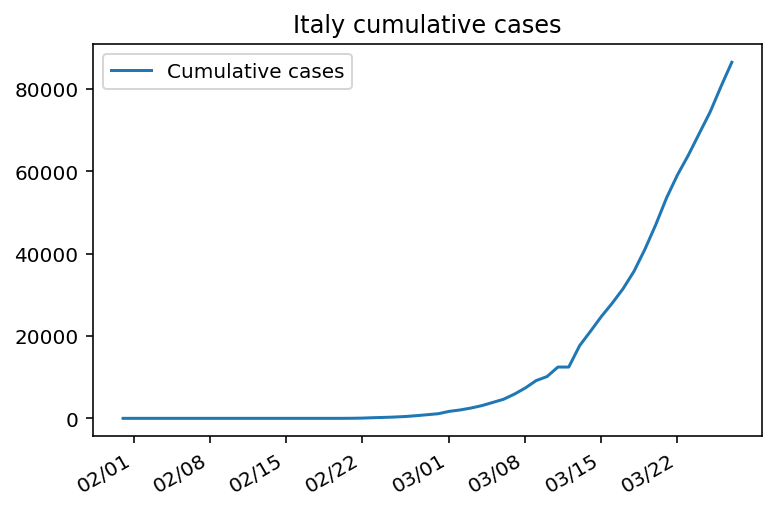

In [20]:
italy = data[data['Country/Region'] == 'Italy']
plot_time_series_data(
    x_col = italy.index, 
    y_col = italy["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'Italy cumulative cases'
)

The long tail on the left with low number of confirmed cases will be a problem when we're comparing different regions. Let's create a heuristic to trim data in a way to normalize our data better:

In [21]:
def trim_region_data(region_data, population):
    cutoff = population / 1_000_000
    return region_data[region_data["Confirmed"] >= cutoff]

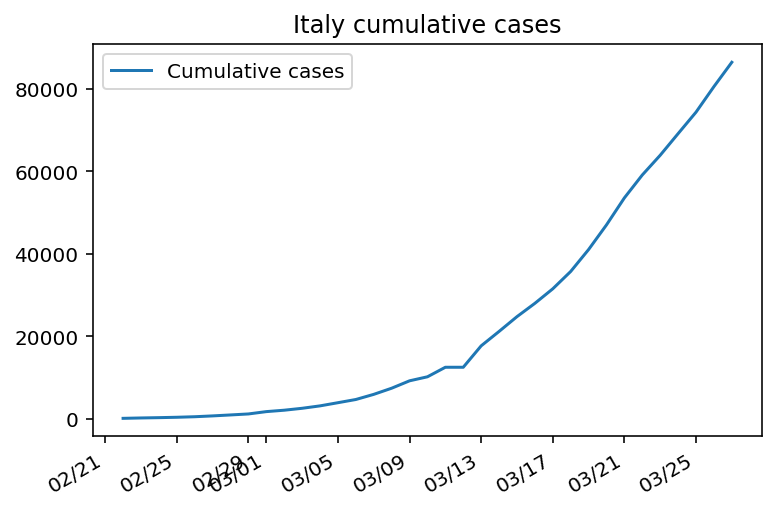

In [22]:
ITALY_POPULATION = 60_480_000

italy = trim_region_data(italy, ITALY_POPULATION)
plot_time_series_data(
    x_col = italy.index, 
    y_col = italy["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'Italy cumulative cases'
)

Italian daily occurrances are also noisy:

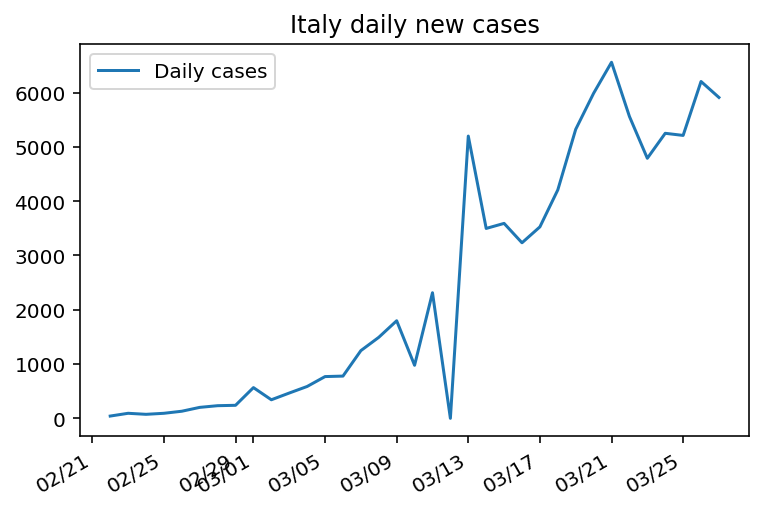

In [23]:
plot_time_series_data(
    x_col = italy.index, 
    y_col = italy["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'Italy daily new cases'
)

Let's manually remove noisy data between 3/12-3/14:

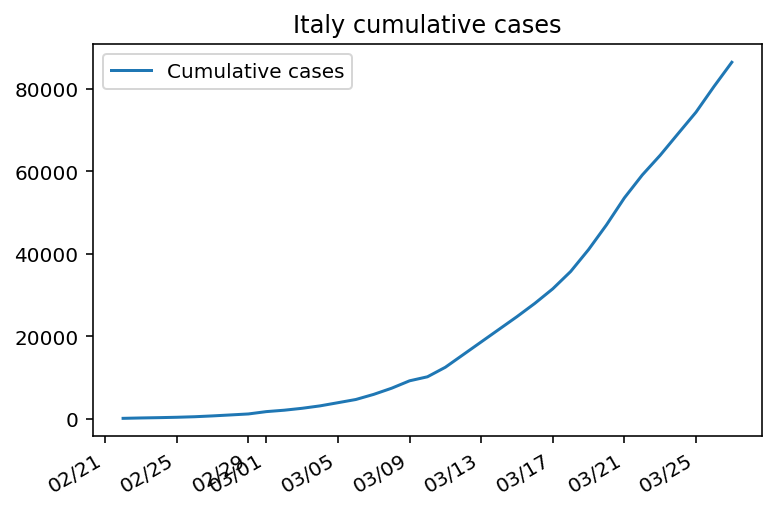

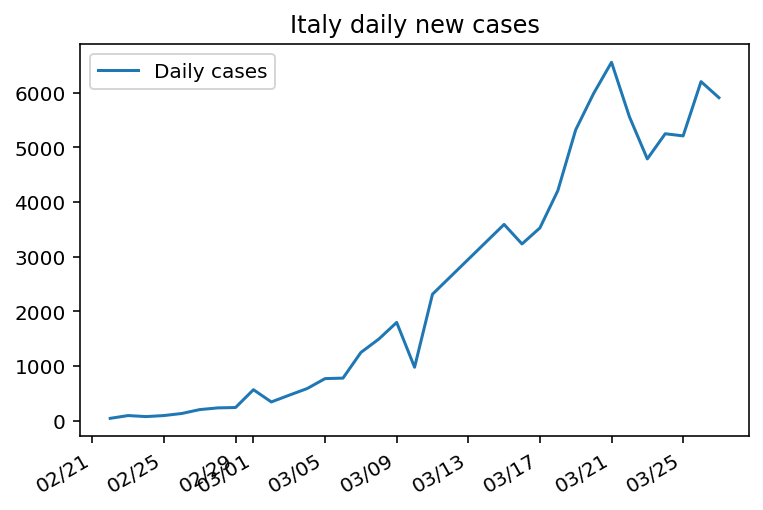

In [24]:
italy_smooth = italy.copy()

for date in ['2020-03-12', '2020-03-13','2020-03-14']:
    italy_smooth = italy_smooth.drop(data[date:date].index)

plot_time_series_data(
    x_col = italy_smooth.index, 
    y_col = italy_smooth["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'Italy cumulative cases'
)

plot_time_series_data(
    x_col = italy_smooth.index, 
    y_col = italy_smooth["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'Italy daily new cases'
)

What if we compare Italian infection rates to the rest of the world?:

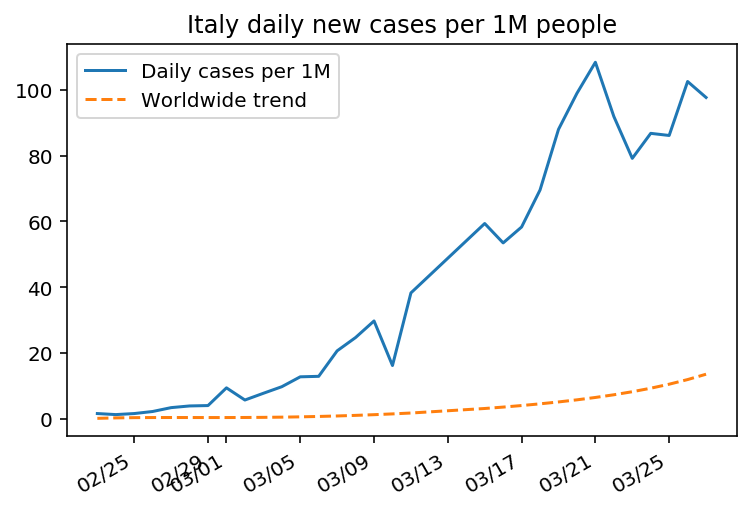

In [25]:
italy_date_offsets = dates_to_date_offsets(italy_smooth.index.values).reshape(-1, 1)[1:]
italy_confirmed_obs = normalize_observations(italy_smooth["Daily Confirmed"].values, ITALY_POPULATION)
italy_predictions_world = world_confirmed_model.predict(polynomial_date_offsets(italy_date_offsets))

plot_time_series_data(
    x_col = italy_smooth.index[1:], 
    y_col = italy_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(italy_predictions_world),
    benchmark_1_label = 'Worldwide trend',
    title = 'Italy daily new cases per 1M people'
)

Italy's observed rate of infection is increasing much faster than the overall worldwide trend. Let's generate the polynomial model for Italy so we can further benchmark other geographic areas:

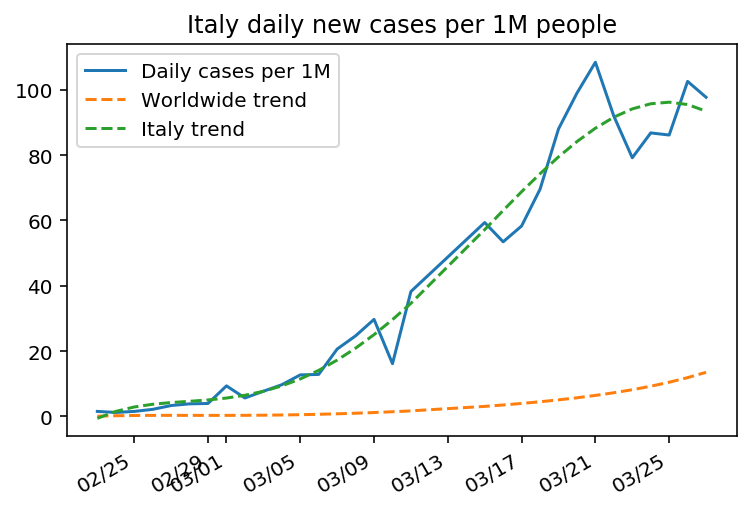

In [26]:
# Refit model
italy_confirmed_model = polynomial_regression(italy_date_offsets, italy_confirmed_obs.reshape(-1, 1)[1:])

# Graph predictions
italy_predictions_italy = italy_confirmed_model.predict(polynomial_date_offsets(italy_date_offsets))

plot_time_series_data(
    x_col = italy_smooth.index[1:], 
    y_col = italy_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(italy_predictions_world),
    benchmark_1_label = 'Worldwide trend',
    benchmark_2 = np.array(italy_predictions_italy),
    benchmark_2_label = 'Italy trend',
    title = 'Italy daily new cases per 1M people'
)

## Confirmed cases in the US
Let's look at US cumulative confirmed cases:

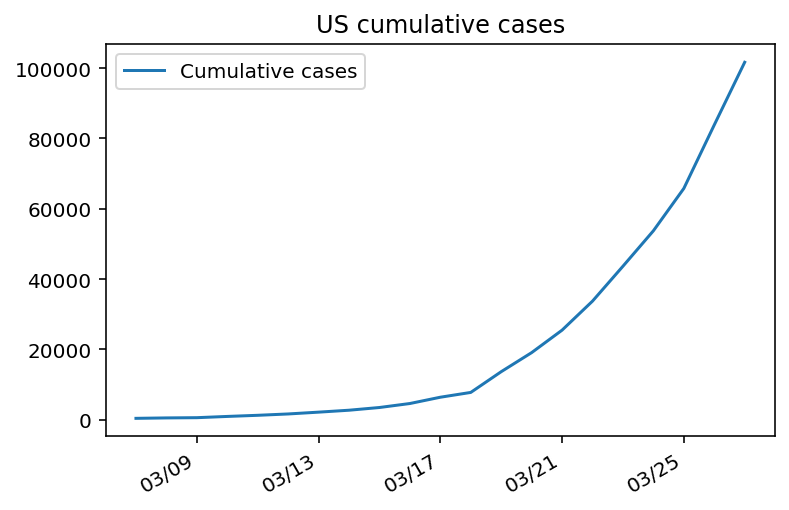

In [27]:
USA_POPULATION = 327_200_000
usa = data.loc[data['Country/Region'] == 'US']
usa = usa.groupby(usa.index).sum()
usa = trim_region_data(usa, USA_POPULATION)

plot_time_series_data(
    x_col = usa.index, 
    y_col = usa["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'US cumulative cases'
)

Daily confirmed cases are likewise exponentially growing:

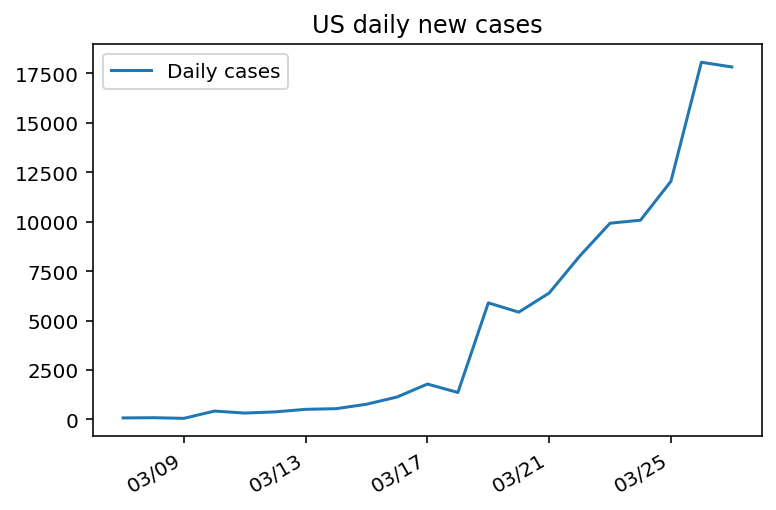

In [28]:
plot_time_series_data(
    x_col = usa.index, 
    y_col = usa["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'US daily new cases'
)

Let's compare the US with the rest of the world and Italy:

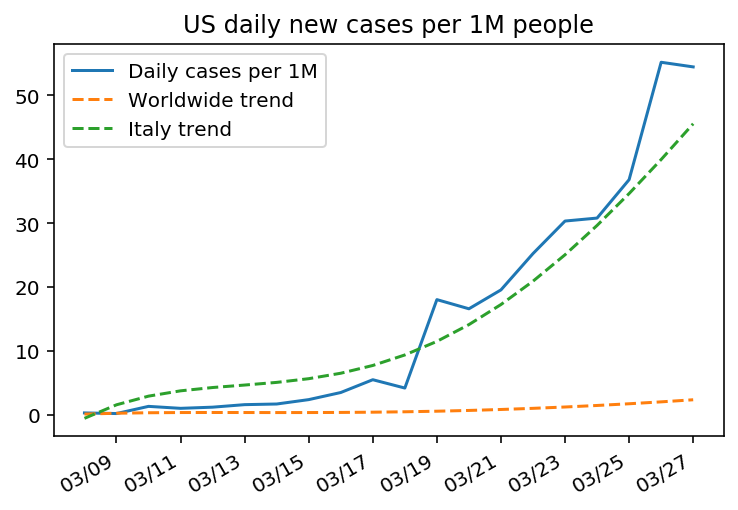

In [29]:
usa_date_offsets = dates_to_date_offsets(usa.index.values).reshape(-1, 1)[1:]
usa_confirmed_obs = normalize_observations(usa["Daily Confirmed"].values, USA_POPULATION)
usa_predictions_world = world_confirmed_model.predict(polynomial_date_offsets(usa_date_offsets))
usa_predictions_italy = italy_confirmed_model.predict(polynomial_date_offsets(usa_date_offsets))

plot_time_series_data(
    x_col = usa.index[1:], 
    y_col = usa_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(usa_predictions_world),
    benchmark_1_label = 'Worldwide trend',
    benchmark_2 = np.array(usa_predictions_italy),
    benchmark_2_label = 'Italy trend',
    title = 'US daily new cases per 1M people'
)

Note that like Italy, US rate of infection increase is outpacing the world overall. The US is roughly following the same trajectory as Italy; just at an earlier stage.

## Confirmed cases in the state of New York

Let's look at New York cumulative confirmed cases:

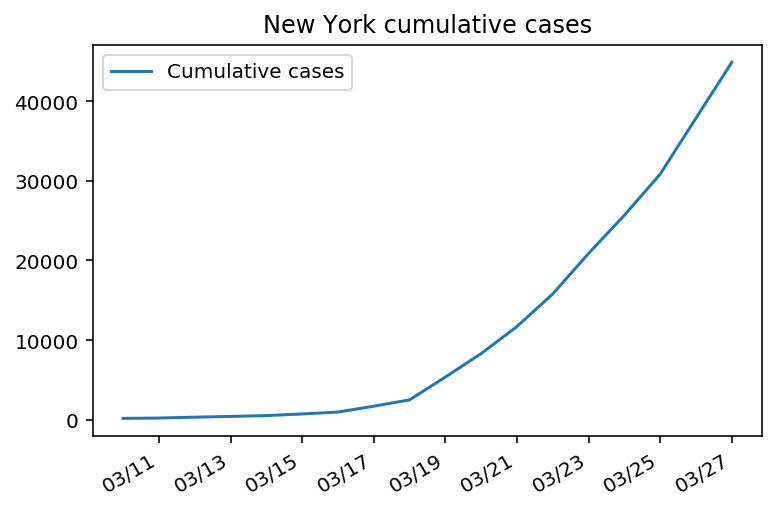

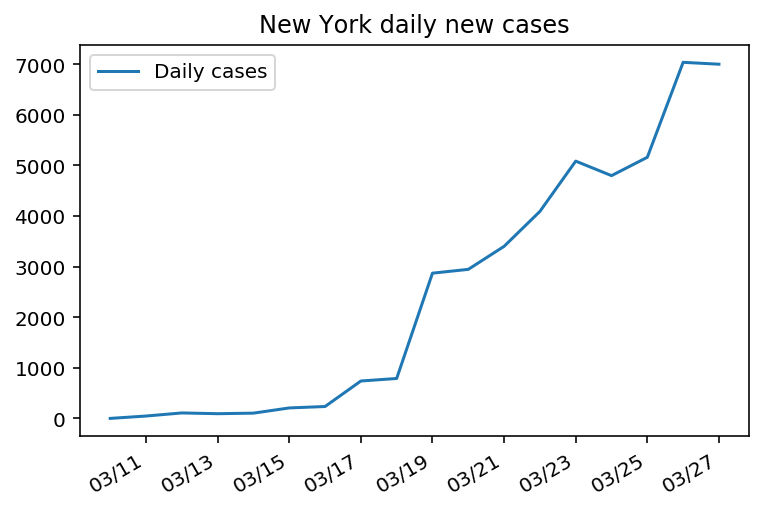

In [39]:
ny = data.loc[data['Province/State'] == 'New York']
ny = ny.groupby(ny.index).sum()

plot_time_series_data(
    x_col = ny.index, 
    y_col = ny["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'New York cumulative cases'
)

plot_time_series_data(
    x_col = ny.index, 
    y_col = ny["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'New York daily new cases'
)

New York daily occurances clearly show a consistent exponential trend. Here's how New York's population-adjusted daily cases compare against our two benchmarks:

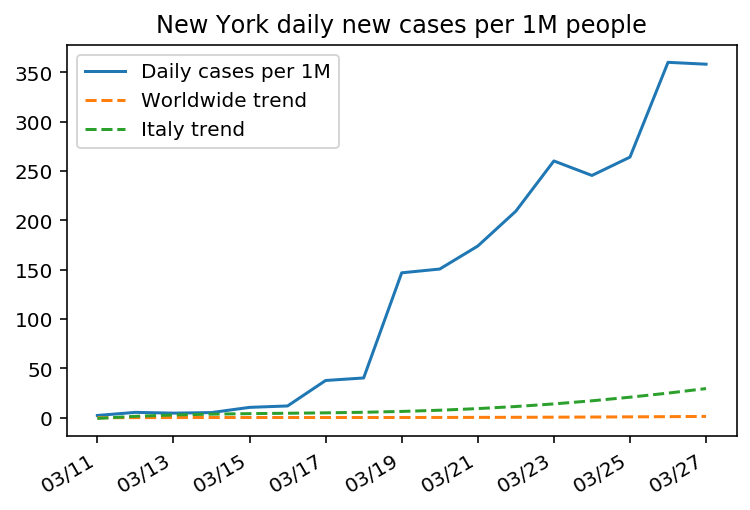

In [40]:
NY_POPULATION = 19_540_000

ny_date_offsets = dates_to_date_offsets(ny.index.values).reshape(-1, 1)[1:]
ny_confirmed_obs = normalize_observations(ny["Daily Confirmed"].values, NY_POPULATION)
ny_predictions_world = world_confirmed_model.predict(polynomial_date_offsets(ny_date_offsets))
ny_predictions_italy = italy_confirmed_model.predict(polynomial_date_offsets(ny_date_offsets))

plot_time_series_data(
    x_col = ny.index[1:], 
    y_col = ny_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(ny_predictions_world),
    benchmark_1_label = 'Worldwide trend',
    benchmark_2 = np.array(ny_predictions_italy),
    benchmark_2_label = 'Italy trend',
    title = 'New York daily new cases per 1M people'
)

In New York, the rate of confirmed cases is already _much_ higher than Italy; and it has only been spreading a fraction of the time.

## Confirmed cases in Washington DC

Let's look at Washington DC cumulative confirmed cases:

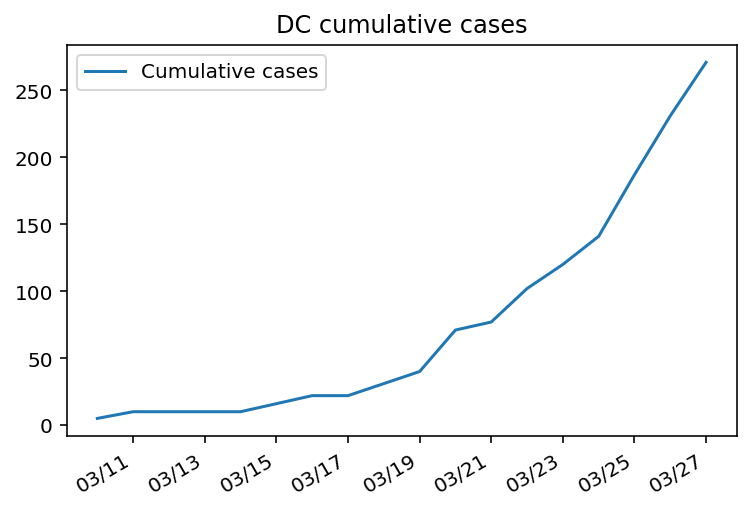

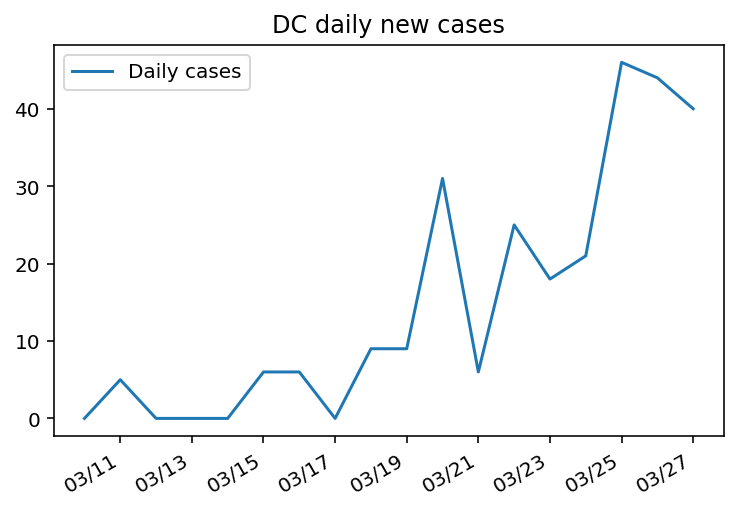

In [33]:
dc = data.loc[data['Province/State'] == 'District of Columbia']

plot_time_series_data(
    x_col = dc.index, 
    y_col = dc["Confirmed"],
    y_label = 'Cumulative cases',
    title = 'DC cumulative cases'
)

plot_time_series_data(
    x_col = dc.index, 
    y_col = dc["Daily Confirmed"],
    y_label = 'Daily cases',
    title = 'DC daily new cases'
)

Daily confirmed cases are noisy, both because there are days with negative confirmed cases, and because the sample size is small. Regardless, the growth appears exponential.

Benchmarked against worldwide and Italian predicted daily new cases:

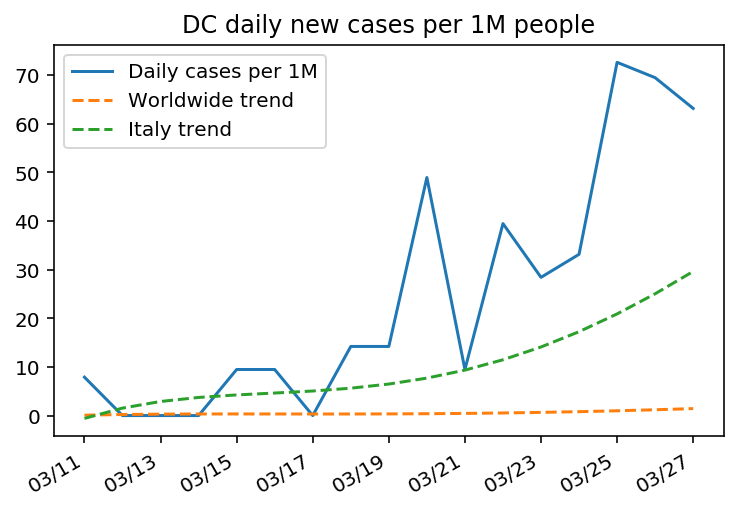

In [34]:
DC_POPULATION = 633_427

dc_date_offsets = dates_to_date_offsets(dc.index.values).reshape(-1, 1)[1:]
dc_confirmed_obs = normalize_observations(dc["Daily Confirmed"].values, DC_POPULATION)
dc_predictions_world = world_confirmed_model.predict(polynomial_date_offsets(dc_date_offsets))
dc_predictions_italy = italy_confirmed_model.predict(polynomial_date_offsets(dc_date_offsets))

plot_time_series_data(
    x_col = dc.index[1:], 
    y_col = dc_confirmed_obs[1:],
    y_label = 'Daily cases per 1M',
    benchmark_1 = np.array(dc_predictions_world),
    benchmark_1_label = 'Worldwide trend',
    benchmark_2 = np.array(dc_predictions_italy),
    benchmark_2_label = 'Italy trend',
    title = 'DC daily new cases per 1M people'
)

## Last week's confirmed cases by country

Let's get the daily new confirmed cases by country:

In [35]:
country_confirmed = data[['Country/Region', 'Daily Confirmed']].copy() \
    .groupby([data.index, 'Country/Region']) \
    .sum() \
    .reset_index() \
    .set_index('Last Update')

prev_week = country_confirmed['2020-03-21':'2020-03-27'] \
    .groupby('Country/Region') \
    .sum() \
    .rename(columns={'Daily Confirmed': 'Weekly Confirmed'}) \
    .sort_values(by=['Weekly Confirmed'], ascending=False)

TOTAL_WEEKLY_CONFIRMED = prev_week.sum()

prev_week['Percentage Confirmed'] = prev_week.apply(
    func=lambda row: 100 * row['Weekly Confirmed'] / TOTAL_WEEKLY_CONFIRMED,
    axis=1
)

prev_week[0:10]

,Weekly Confirmed,Percentage Confirmed
Country/Region,,
US,82560.0,25.708974
Spain,45309.0,14.109107
Italy,39477.0,12.293037
Germany,31023.0,9.660483
France,20733.0,6.456204
Iran,12688.0,3.951011
United Kingdom,10731.0,3.341606
Switzerland,7634.0,2.377208
Netherlands,5644.0,1.757527


In [36]:
def plot_pie_chart(labels, percentages, title = "No Title"):
    fig1, ax1 = plt.subplots()
    ax1.pie(percentages, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
    ax1.axis('equal')
    plt.title(title)
    plt.show()

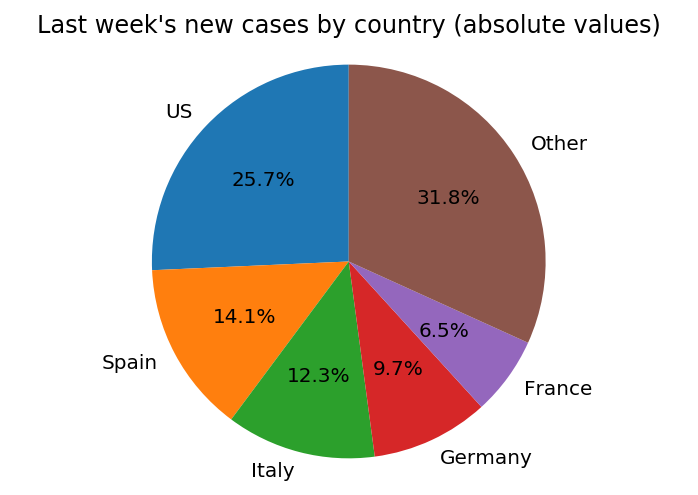

In [37]:
MAX_TO_SHOW = 5

labels = prev_week.index[0:MAX_TO_SHOW].values
labels = np.append(labels, "Other")

percentages = prev_week['Percentage Confirmed'][0:MAX_TO_SHOW].values
percentages = np.append(percentages, prev_week['Percentage Confirmed'][MAX_TO_SHOW:].sum())

plot_pie_chart(
    labels = labels,
    percentages = percentages,
    title = 'Last week\'s new cases by country (absolute values)'
)

However, to understand the impact of these rates on the respective countries, we should adjust these values to account for population size.

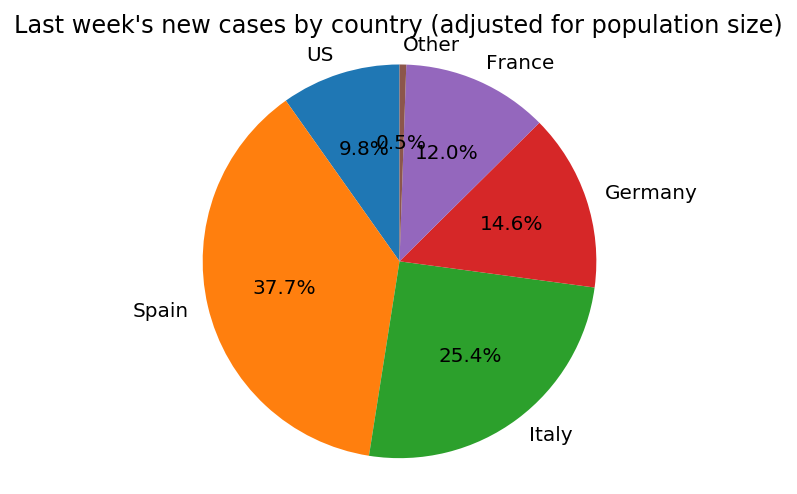

In [38]:
SPAIN_POPULATION = 46_660_000
GERMANY_POPULATION = 82_790_000
FRANCE_POPULATION = 66_990_000

populations = np.array([ USA_POPULATION, SPAIN_POPULATION, ITALY_POPULATION, \
                        GERMANY_POPULATION, FRANCE_POPULATION])

populations = np.append(populations, WORLD_POPULATION - populations.sum())

new_percentages = np.array([])

for i in range(0, percentages.size):
    new_percentages = np.append(new_percentages, percentages[i] / populations[i])

total = new_percentages.sum()
new_percentages = np.array(list(map(lambda x: x / total, new_percentages)))

plot_pie_chart(
    labels = labels,
    percentages = new_percentages,
    title = 'Last week\'s new cases by country (adjusted for population size)'
)

Even though the US is the top country by absolute counts of new cases over the last week, if you adjust for its population size, it is in fifth place.

Spain and Italy have disproportionately higher rates of new cases when accounting for population size.

## Conclusions

As of 3/27:

* The data for some regions are noisier than others
* **US** has the most cumulative cases; however, this is misleading unless you take population into account
* **Italy** has twice the number of daily new cases per 1M people than the US (~100 and ~50, respectively)
* **New York** has nearly ~350 daily new cases. This happened over a 16 day period, whereas Italy's growth was over a month. New York's daily rate is approximately 10 times greater than Italy.
* Unsurprisingly, the two reviewed densely populated areas (e.g., New York, DC) are showing higher growth in new cases; even more than countries like Italy.
* As of yet, none of the select US regions reviewed have strong evidence of reversing daily case growth
* Over the last week, **US** has the largest number of new confirmed cases of COVID-19. However, if you adjust for population size, **Spain** and **Italy** have much higher rates of new cases.